### **This notebook aims to classify the exosome status based on a featureset derrived from the peaks.**

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *

Read the spectral data

In [2]:
#df = pd.read_csv("../data/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239205 entries, 0 to 6239204
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 285.6+ MB


Locate and correct the spikes

In [5]:
df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [6]:
lam = 10 ** 8
p = 0.05

df['Baseline'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
df['Baseline_Corrected_Absorbance'] = df['Despiked_Absorbance'] - df['Baseline']

Remove the noise from the spectra using Savitzky–Golay-filtering

In [7]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

Scale the absorbances of each spectra by the max value.

In [8]:
df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

#### **Peak Finding using one Spectra**

In [9]:
sample = df[df['SpecID'] == "210526-3-04"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Despiked_Absorbance,Baseline,Baseline_Corrected_Absorbance,Smoothed_Absorbance,Scaled_Absorbance
6206421,210526-3-04,293,400.22778,2418.5078,210526-3,Hyperglycemia,2418.5078,2413.870498,4.637302,1.811072,0.003864
6206422,210526-3-04,294,400.91116,2425.2903,210526-3,Hyperglycemia,2425.2903,2414.177106,11.113194,14.053420,0.029984
6206423,210526-3-04,295,401.59454,2440.9182,210526-3,Hyperglycemia,2440.9182,2414.483714,26.434486,24.795462,0.052904
6206424,210526-3-04,296,402.27789,2452.6968,210526-3,Hyperglycemia,2452.6968,2414.790321,37.906479,34.037197,0.072622
6206425,210526-3-04,297,402.96127,2452.4475,210526-3,Hyperglycemia,2452.4475,2415.096929,37.350571,41.778626,0.089139
...,...,...,...,...,...,...,...,...,...,...,...
6208465,210526-3-04,2337,1797.03870,1994.6351,210526-3,Hyperglycemia,1994.6351,1949.864409,44.770691,54.382945,0.116032
6208466,210526-3-04,2338,1797.72200,2007.0331,210526-3,Hyperglycemia,2007.0331,1948.375425,58.657675,54.596924,0.116488
6208467,210526-3-04,2339,1798.40550,2007.3999,210526-3,Hyperglycemia,2007.3999,1946.886442,60.513458,50.747123,0.108274
6208468,210526-3-04,2340,1799.08890,1982.2590,210526-3,Hyperglycemia,1982.2590,1945.397458,36.861542,42.833543,0.091390


Find the peaks of each the differently smoothed spectra

In [10]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'], distance=152, prominence=42/3200, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

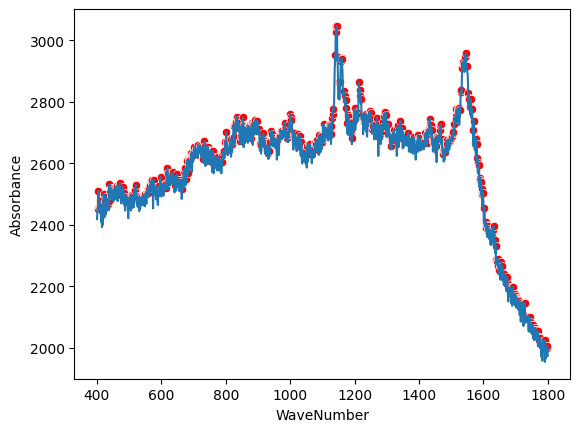

In [11]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

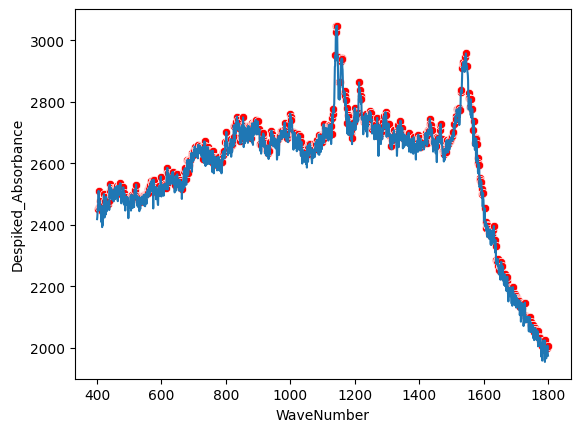

In [12]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

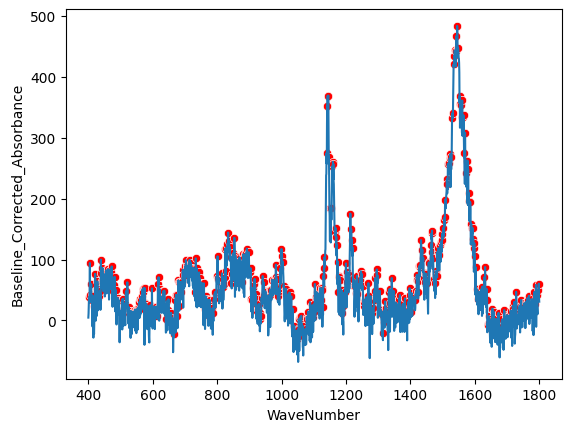

In [13]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

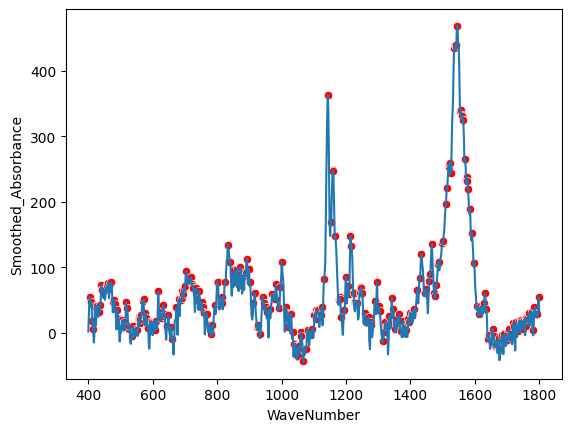

In [14]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

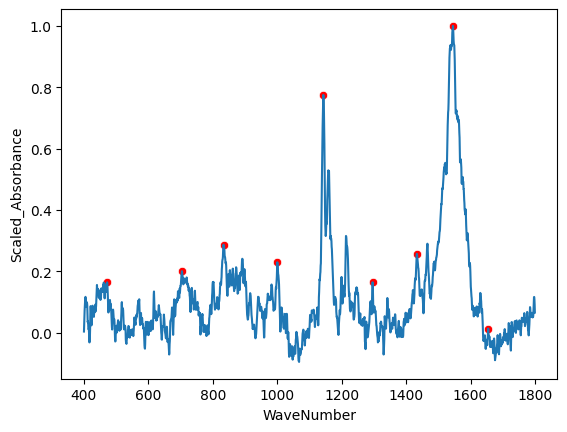

In [15]:
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[normalised_peaks], x="WaveNumber", y="Scaled_Absorbance", color="red")

The average baseline corrected spectrum of each status

<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

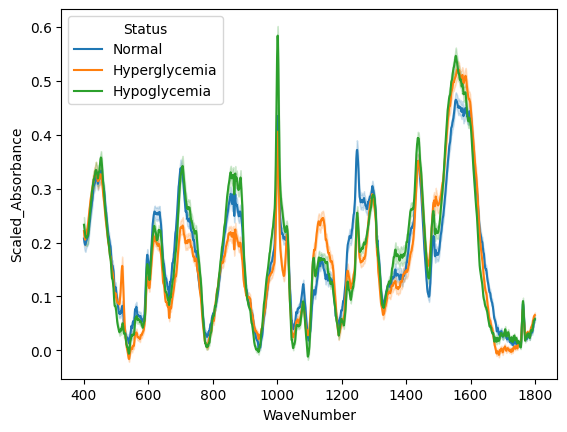

In [16]:
sns.lineplot(data=df, x='WaveNumber', y='Scaled_Absorbance', hue='Status')

#### **Machine Learning with Peak Features**

In [17]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [18]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [19]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [20]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [21]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.239166,0.201604,0.174807,0.158777,0.153512,0.160096,0.180385,0.179275,0.152444,0.151990,...,0.079373,0.076015,0.072722,0.063280,0.052400,0.031250,0.001627,-0.036469,-0.083038,Normal
201210-1-01,0.125393,0.127835,0.131718,0.137042,0.143806,0.164082,0.177289,0.174876,0.172088,0.178656,...,0.045390,0.046211,0.040787,0.042556,0.037407,0.043596,0.051071,0.059833,0.069882,Normal
201210-1-02,0.046999,0.045158,0.043284,0.041378,0.039440,0.040015,0.037390,0.033528,0.029662,0.028759,...,-0.006536,-0.002810,-0.001793,-0.000692,-0.002135,-0.003198,-0.004575,-0.006267,-0.008273,Normal
201210-1-03,0.035453,0.039578,0.043635,0.047622,0.051539,0.062514,0.064909,0.060922,0.052433,0.043006,...,-0.018042,-0.018339,-0.017414,-0.016280,-0.009435,-0.007084,-0.005027,-0.003264,-0.001796,Normal
201210-1-04,0.207055,0.193484,0.180824,0.169075,0.158237,0.151623,0.137718,0.124700,0.114798,0.096012,...,-0.079881,-0.069882,-0.082514,-0.098689,-0.129789,-0.118470,-0.087764,-0.037673,0.031805,Normal


##### **1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.**

In [23]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [24]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [25]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8266 +/- 0.0223
ExtraTreesClassifier Cross-Validation Accuracy: 0.8476 +/- 0.0168


#### **2. Using Peak Statistics**

This uses statistical properties of the peaks in each sample to be used as additional features.

In [26]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [27]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Baseline,Absorbance
93,201210-1-00,386,463.78131,201210-1,Normal,1717.650813,0.322936
435,201210-1-00,728,697.49432,201210-1,Normal,1664.663287,1.000000
732,201210-1-00,1025,900.45557,201210-1,Normal,1622.029708,0.698844
1075,201210-1-00,1368,1134.85190,201210-1,Normal,1552.734868,0.214153
1242,201210-1-00,1535,1248.97500,201210-1,Normal,1515.248693,0.269624
...,...,...,...,...,...,...,...
6227976,210526-3-49,1358,1128.01820,210526-3,Hyperglycemia,1394.336979,0.490223
6228222,210526-3-49,1604,1296.12760,210526-3,Hyperglycemia,1364.530269,0.575589
6228433,210526-3-49,1815,1440.31880,210526-3,Hyperglycemia,1307.988118,0.711816
6228612,210526-3-49,1994,1562.64230,210526-3,Hyperglycemia,1226.319112,0.732847


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

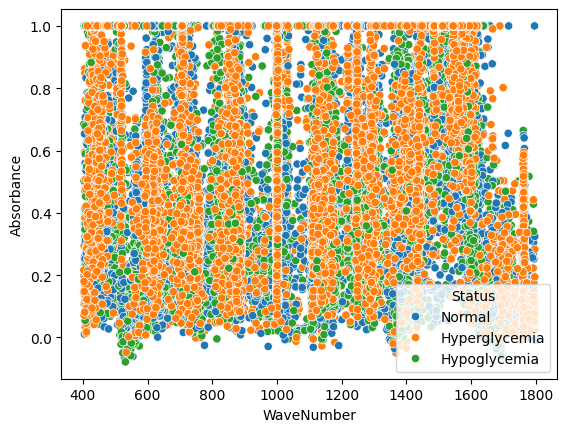

In [28]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

In [29]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

27009
27009
27009


/tmp/ipykernel_20095/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_20095/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [30]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Baseline,Absorbance,PeakWidths,PeakProminences
93,201210-1-00,386,463.78131,201210-1,Normal,1717.650813,0.322936,10.595200,0.245767
435,201210-1-00,728,697.49432,201210-1,Normal,1664.663287,1.000000,45.264515,1.122352
732,201210-1-00,1025,900.45557,201210-1,Normal,1622.029708,0.698844,107.635997,0.831167
1075,201210-1-00,1368,1134.85190,201210-1,Normal,1552.734868,0.214153,6.858794,0.259773
1242,201210-1-00,1535,1248.97500,201210-1,Normal,1515.248693,0.269624,18.272212,0.288955


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [31]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [32]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [33]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,0.463817,0.277887,8,1.0,0.207320,52.115674,54.479347,157.744177,6.858794,0.524016,0.322780,1.122352,0.245767,Normal
201210-1-01,0.509902,0.308107,9,1.0,0.137444,36.512730,18.832612,63.772155,9.374862,0.555184,0.351386,1.092058,0.163588,Normal
201210-1-02,0.249824,0.340109,8,1.0,0.023130,24.481746,10.505831,41.499656,11.788886,0.252754,0.351850,1.024010,0.036395,Normal
201210-1-03,0.508773,0.387361,8,1.0,0.044173,33.282415,19.357075,59.948532,7.017930,0.515952,0.412844,1.036999,0.061691,Normal
201210-1-04,0.435031,0.240422,10,1.0,0.117375,45.633593,43.465571,160.845644,11.052511,0.478308,0.292727,1.129789,0.182337,Normal


In [34]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.4873 +/- 0.0285
ExtraTreesClassifier Cross-Validation Accuracy: 0.4962 +/- 0.0292


Combine these peak statistics with the full wavelength

In [35]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [36]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1793.6218,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.463817,0.277887,8,1.0,0.207320,52.115674,54.479347,157.744177,6.858794,0.524016,...,0.078573,0.079373,0.076015,0.072722,0.063280,0.052400,0.031250,0.001627,-0.036469,-0.083038
201210-1-01,0.509902,0.308107,9,1.0,0.137444,36.512730,18.832612,63.772155,9.374862,0.555184,...,0.024442,0.045390,0.046211,0.040787,0.042556,0.037407,0.043596,0.051071,0.059833,0.069882
201210-1-02,0.249824,0.340109,8,1.0,0.023130,24.481746,10.505831,41.499656,11.788886,0.252754,...,-0.009353,-0.006536,-0.002810,-0.001793,-0.000692,-0.002135,-0.003198,-0.004575,-0.006267,-0.008273
201210-1-03,0.508773,0.387361,8,1.0,0.044173,33.282415,19.357075,59.948532,7.017930,0.515952,...,-0.019081,-0.018042,-0.018339,-0.017414,-0.016280,-0.009435,-0.007084,-0.005027,-0.003264,-0.001796
201210-1-04,0.435031,0.240422,10,1.0,0.117375,45.633593,43.465571,160.845644,11.052511,0.478308,...,-0.074698,-0.079881,-0.069882,-0.082514,-0.098689,-0.129789,-0.118470,-0.087764,-0.037673,0.031805


In [37]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8253 +/- 0.0218
ExtraTreesClassifier Cross-Validation Accuracy: 0.8529 +/- 0.0217


#### **3. Creating a Uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [38]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [39]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

27009
27009
27009


/tmp/ipykernel_20095/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_20095/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [40]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Baseline,Absorbance,PeakWidths,PeakProminences
93,201210-1-00,386,463.78131,201210-1,Normal,1717.650813,0.322936,10.595200,0.245767
435,201210-1-00,728,697.49432,201210-1,Normal,1664.663287,1.000000,45.264515,1.122352
732,201210-1-00,1025,900.45557,201210-1,Normal,1622.029708,0.698844,107.635997,0.831167
1075,201210-1-00,1368,1134.85190,201210-1,Normal,1552.734868,0.214153,6.858794,0.259773
1242,201210-1-00,1535,1248.97500,201210-1,Normal,1515.248693,0.269624,18.272212,0.288955


Assign Peaks to bins of a fixed wavelength interval.

In [41]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_20095/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [42]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Baseline,Absorbance,PeakWidths,PeakProminences,Bin
93,201210-1-00,386,463.78131,201210-1,Normal,1717.650813,0.322936,10.595200,0.245767,450-475
435,201210-1-00,728,697.49432,201210-1,Normal,1664.663287,1.000000,45.264515,1.122352,675-700
732,201210-1-00,1025,900.45557,201210-1,Normal,1622.029708,0.698844,107.635997,0.831167,900-925
1075,201210-1-00,1368,1134.85190,201210-1,Normal,1552.734868,0.214153,6.858794,0.259773,1125-1150
1242,201210-1-00,1535,1248.97500,201210-1,Normal,1515.248693,0.269624,18.272212,0.288955,1225-1250


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [43]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

/tmp/ipykernel_20095/2531638340.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [44]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,False,False,False,0.214153,False,False,False,0.269624,...,False,False,False,False,False,107.635997,False,False,False,Normal
201210-1-01,0.426785,False,False,False,False,0.227311,False,False,False,False,...,False,False,False,False,57.760459,False,False,False,False,Normal
201210-1-02,False,0.10423,False,False,False,False,False,False,False,0.035474,...,False,False,False,False,False,24.157095,False,False,False,Normal
201210-1-03,False,False,False,False,False,False,0.499576,False,False,False,...,False,False,False,False,False,58.861362,False,False,False,Normal
201210-1-04,0.448385,False,False,False,False,False,False,0.282842,False,False,...,False,False,False,45.568275,False,False,False,False,False,Normal


In [45]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.6880 +/- 0.0256
ExtraTreesClassifier Cross-Validation Accuracy: 0.6811 +/- 0.0261


Merge with the full spectrum.

In [46]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [47]:
bins_and_spectrum.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,1793.6218,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,False,False,False,False,False,0.214153,False,False,False,0.269624,...,0.078573,0.079373,0.076015,0.072722,0.063280,0.052400,0.031250,0.001627,-0.036469,-0.083038
201210-1-01,0.426785,False,False,False,False,0.227311,False,False,False,False,...,0.024442,0.045390,0.046211,0.040787,0.042556,0.037407,0.043596,0.051071,0.059833,0.069882
201210-1-02,False,0.10423,False,False,False,False,False,False,False,0.035474,...,-0.009353,-0.006536,-0.002810,-0.001793,-0.000692,-0.002135,-0.003198,-0.004575,-0.006267,-0.008273
201210-1-03,False,False,False,False,False,False,0.499576,False,False,False,...,-0.019081,-0.018042,-0.018339,-0.017414,-0.016280,-0.009435,-0.007084,-0.005027,-0.003264,-0.001796
201210-1-04,0.448385,False,False,False,False,False,False,0.282842,False,False,...,-0.074698,-0.079881,-0.069882,-0.082514,-0.098689,-0.129789,-0.118470,-0.087764,-0.037673,0.031805


In [48]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8223 +/- 0.0224
ExtraTreesClassifier Cross-Validation Accuracy: 0.8496 +/- 0.0214


In [49]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using KFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.8223 +/- 0.0224
Top 10 Features: Index(['1110.2506', '997.49432', '517.76764', '1251.7084', '1236.6743',
       '517.08429', '1241.4579', '518.45105', '1235.3075', '999.54443'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.8496 +/- 0.0214
Top 10 Features: Index(['998.17767', '998.86102', '1002.2779', 'PeakProminences_1000-1025',
       '1000.2278', 'Absorbance_1000-1025', '1000.9111', '886.78815',
       '997.49432', '517.08429'],
      dtype='object')
